In [3]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Text(0, 0.5, 'strain')

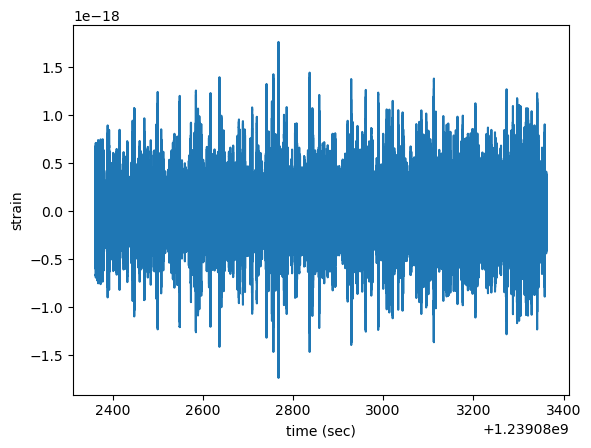

In [6]:
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')

In [7]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
data.delta_t

0.000244140625

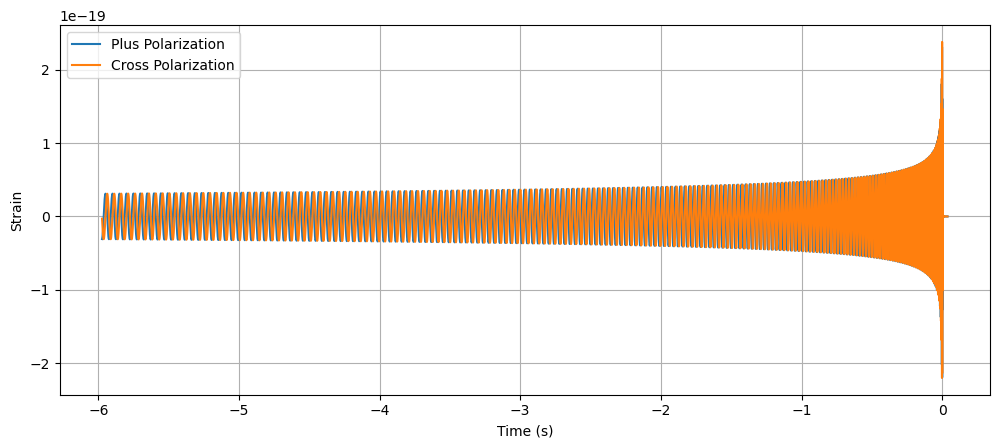

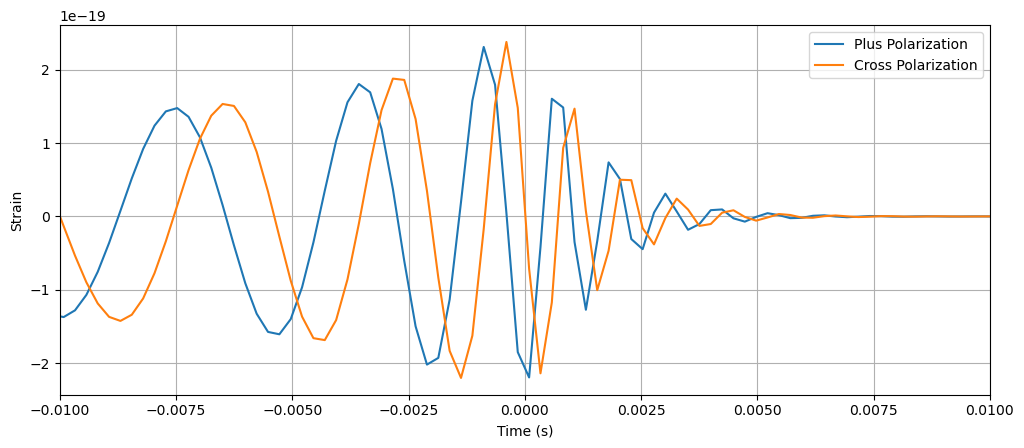

In [8]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=0.000244140625,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

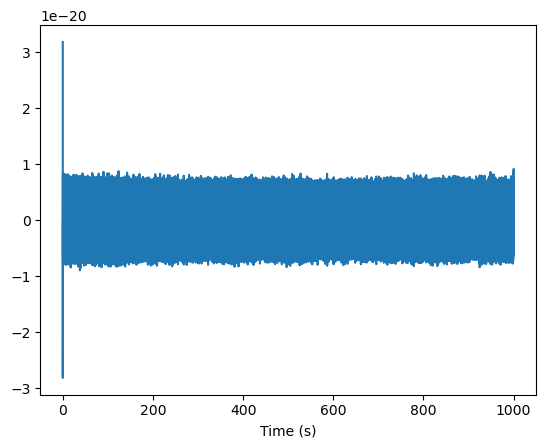

In [14]:
%matplotlib inline

import pylab
from pycbc.filter import resample_to_delta_t, highpass

pycbc_strain = d
strain = pycbc_strain
strain = highpass(strain, 20.0)
strain = resample_to_delta_t(strain, 1.0/2048)
pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

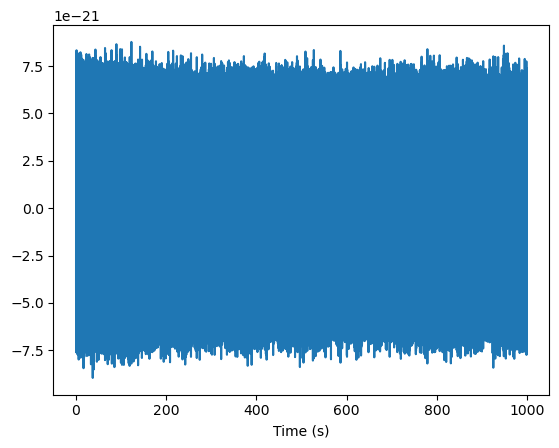

0.001002004008016032

In [15]:
conditioned = strain.crop(1, 1)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()
conditioned.delta_f

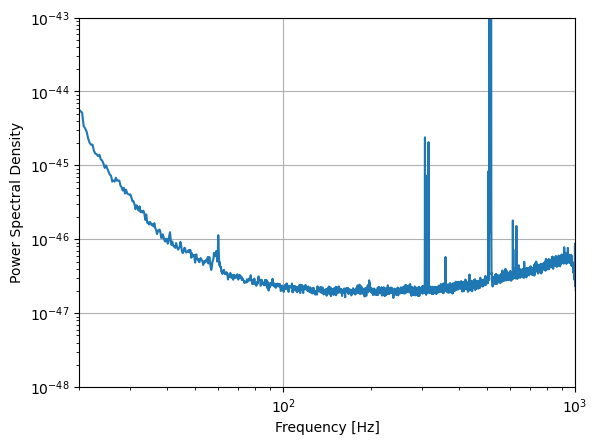

In [20]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
import matplotlib.pyplot as pp
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)
pp.xlim(20, 1000)
pp.ylim(1e-48, 1e-43)
pp.loglog(psd.sample_frequencies, psd)

pp.xlabel('Frequency [Hz]')
pp.ylabel('Power Spectral Density')
pp.grid()
pp.show()

In [21]:
psd = interpolate(psd, conditioned.delta_f)

In [22]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

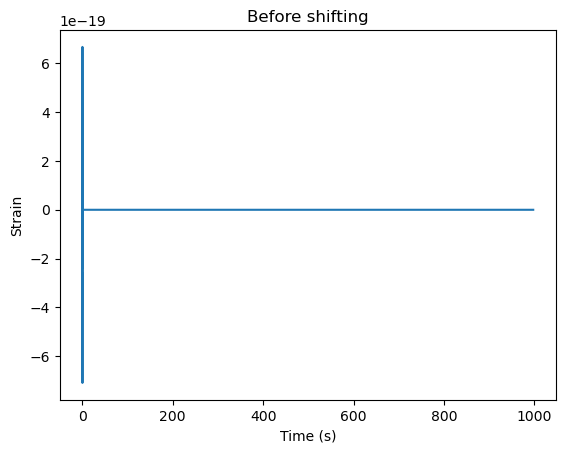

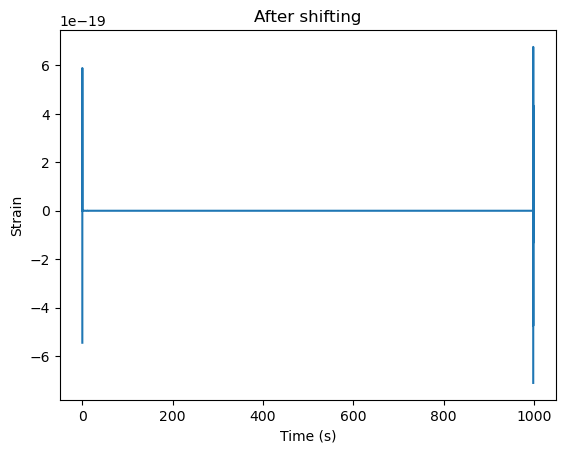

In [23]:
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

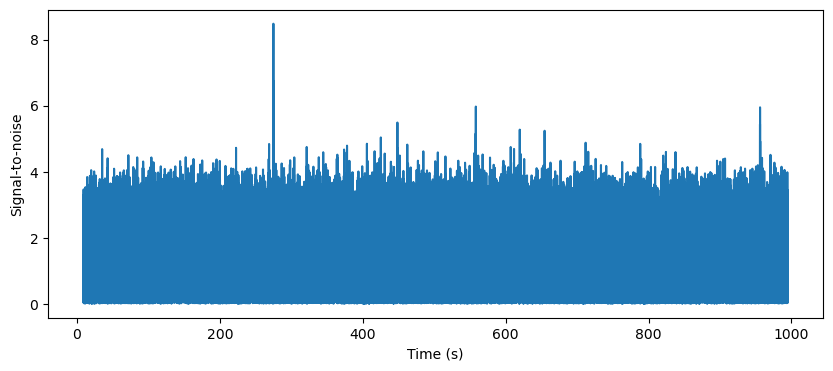

We found a signal at 274.92529296900005s with SNR 8.483493556722214


In [26]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]


print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

In [27]:
#SNR of 8.48 so we can claim that GW are there.

In [28]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

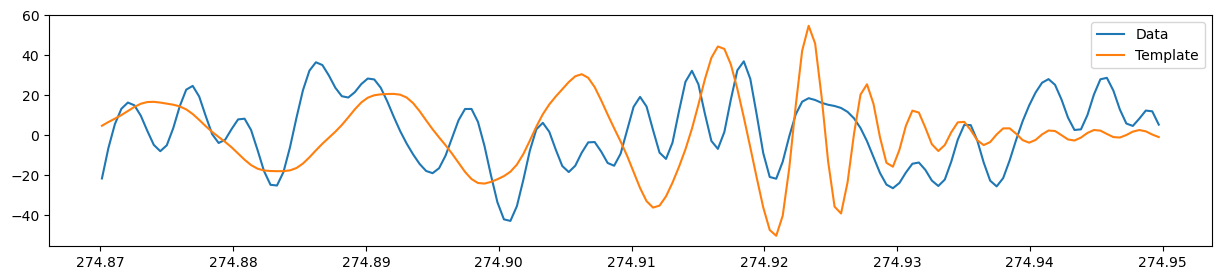

In [34]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(274.87, 274.95)
white_template = white_template.time_slice(274.87, 274.95)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

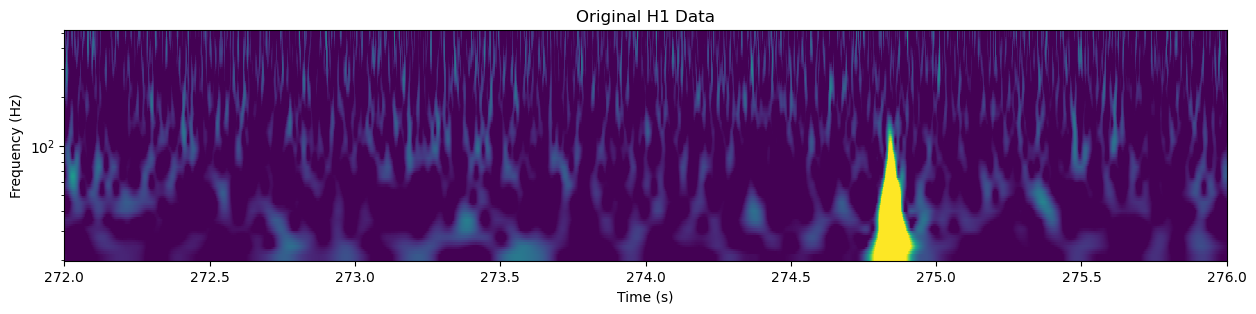

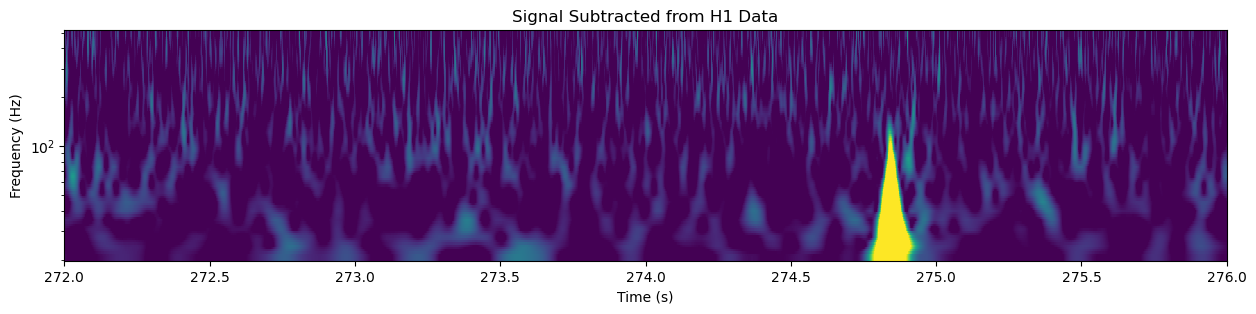

In [35]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(272, 276)
    pylab.show()

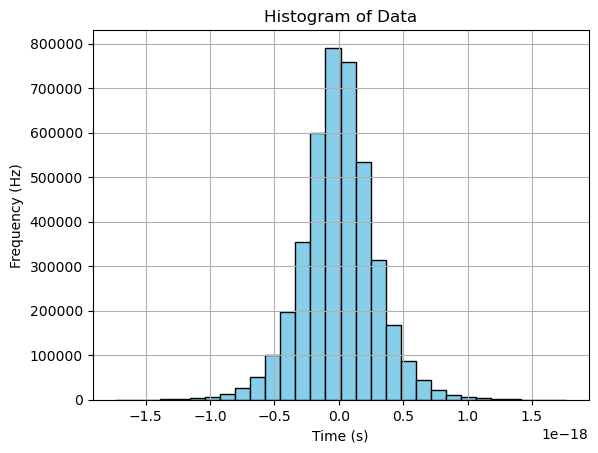

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plotting the histogram
plt.hist(d, bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Histogram of Data')
plt.grid(True)  # Adding grid lines
plt.show()

In [47]:
from pycbc.waveform import get_fd_waveform

# Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2", mass1=3, mass2=3, delta_f=1.0/200.0, distance=500, f_lower=20.0, f_final=2048.0)